# Transfer learning with SpinalNet fully connected layer for accident detection from CCTV footage.

### We write this code with the help of PyTorch demo:
###    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## More scripts are available in earlier versions of the notebook.

### For more code of SpinalNet, please visit: https://github.com/dipuk0506/SpinalNet

# Dataloader and Visualization

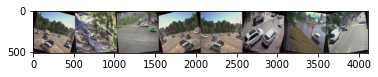

In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy




plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.RandomRotation(15,),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'val': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = '../input/accident-detection-from-cctv-footage/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

# Downloading Model and Changing Fully-connected/ Classifier Layer

In [2]:
#%%

model_ft = models.vgg19_bn(pretrained=True)
num_ftrs = model_ft.classifier[0].in_features

#model_ft = models.resnet18(pretrained=True)
#num_ftrs = model_ft.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 1024
Num_class=2

class SpinalNet_ResNet(nn.Module):
    def __init__(self):
        super(SpinalNet_ResNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            #nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            #nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)
        
    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x
    
class SpinalNet_VGG(nn.Module):
    def __init__(self):
        super(SpinalNet_VGG, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x



net_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, Num_class)
        )


'''
Changing the fully connected layer to SpinalNet or ResNet or VGG
'''

#model_ft.fc = nn.Linear(num_ftrs, Num_class)
#model_ft.fc = SpinalNet_ResNet()

model_ft.classifier = SpinalNet_ResNet()
#model_ft.classifier = net_classifier

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# Training Function

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



# Training with lr=0.01

In [4]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6149 Acc: 0.6726
val Loss: 0.4118 Acc: 0.8265
test Loss: 0.4686 Acc: 0.7600

Epoch 1/4
----------
train Loss: 0.4793 Acc: 0.7737
val Loss: 0.3923 Acc: 0.8265

Epoch 2/4
----------
train Loss: 0.3616 Acc: 0.8420
val Loss: 0.4368 Acc: 0.7755

Epoch 3/4
----------
train Loss: 0.3238 Acc: 0.8710
val Loss: 0.3438 Acc: 0.8878
test Loss: 0.3077 Acc: 0.8800

Epoch 4/4
----------
train Loss: 0.2772 Acc: 0.9014
val Loss: 0.2953 Acc: 0.8980
test Loss: 0.3144 Acc: 0.8600

Training complete in 6m 23s
Best val Acc: 0.897959


# Training with lr=0.001

In [5]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1904 Acc: 0.9191
val Loss: 0.1863 Acc: 0.9490
test Loss: 0.1356 Acc: 0.9500

Epoch 1/4
----------
train Loss: 0.1159 Acc: 0.9558
val Loss: 0.1612 Acc: 0.9490

Epoch 2/4
----------
train Loss: 0.1196 Acc: 0.9570
val Loss: 0.1808 Acc: 0.9490

Epoch 3/4
----------
train Loss: 0.0949 Acc: 0.9583
val Loss: 0.1228 Acc: 0.9490

Epoch 4/4
----------
train Loss: 0.0810 Acc: 0.9697
val Loss: 0.1396 Acc: 0.9490

Training complete in 5m 55s
Best val Acc: 0.948980


## Confusion Matrix

### Validation Data

<AxesSubplot:>

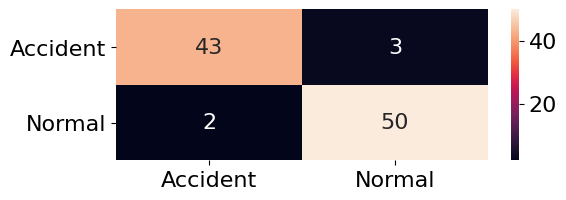

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Accident', 'Normal')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (6,2),dpi=100)
plt.rcParams['font.size'] = '16'
sn.heatmap(df_cm, annot=True, fmt=".0f")

### Test Data

<AxesSubplot:>

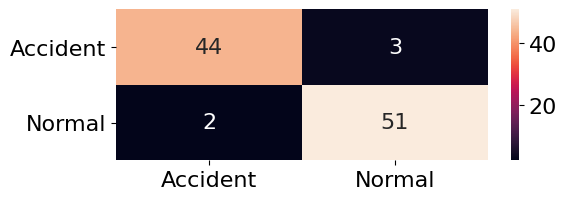

In [7]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (6,2),dpi=100)
plt.rcParams['font.size'] = '16'
sn.heatmap(df_cm, annot=True, fmt=".0f")